# Chronométrage de la génération de features

Nous essayons de déterminer dans ce notebook quelles sont les étapes les plus chronophages de la génération de features, entre lecture, calcul des propriétés géométriques des points dans un nuage de points 3D, et écriture sur le disque.

Les chronométrages ont été effectués via le module `pstats`, pour un ensemble de configuration croisant différents paramètres :
- nombre de points pour lesquels les propriétés ont été calculées (1000, 5000, 10000, 50000);
- nombre de points dans le voisinage du point d'intérêt servant au calcul des propriétés géométriques (20, 50, 100);
- ensemble des propriétés considérées (alphabeta pour les coordonnées barycentriques d'après CANUPO, eigenvalues pour les métriques tirées des valeurs propres du nuage de point local, full pour l'ensemble des métriques).

## Introduction

Import des modules de travail, et lecture du fichier contenant les chronométrages :

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

%matplotlib inline

In [2]:
TIMER_FILE = Path("..", "data", "timers", "timers.csv")

In [3]:
timers = pd.read_csv(str(TIMER_FILE))

In [4]:
timers.shape

(468, 9)

In [5]:
timers.columns

Index(['function', 'nb_points', 'nb_neighbors', 'feature_set', 'nb_calls',
       'total_time', 'total_time_per_call', 'cum_time', 'cum_time_per_call'],
      dtype='object')

## Quelles fonctions ?

On note tout d'abord que les fonctions impliquées diffèrent en fonction de l'ensemble des propriétés:

In [6]:
grouped_timers = timers.groupby(["nb_points", "nb_neighbors", "feature_set"])
grouped_timers["function"].count()

nb_points  nb_neighbors  feature_set
1000       20            alphabeta      10
                         eigenvalues    11
                         full           18
           50            alphabeta      10
                         eigenvalues    11
                         full           18
           100           alphabeta      10
                         eigenvalues    11
                         full           18
5000       20            alphabeta      10
                         eigenvalues    11
                         full           18
           50            alphabeta      10
                         eigenvalues    11
                         full           18
           100           alphabeta      10
                         eigenvalues    11
                         full           18
10000      20            alphabeta      10
                         eigenvalues    11
                         full           18
           50            alphabeta      10
                 

Il y aurait 10 fonctions différentes impliquées pour le set `alphabeta`, 11 pour le set `eigenvalues` et 18 pour le set `full`.

En détail :

In [7]:
timers.loc[timers["feature_set"] == "alphabeta"]["function"].unique()

array(['features.py:54(normalized_eigenvalues)',
       'features.py:72(triangle_variance_space)',
       'features.py:6(<module>)', 'extract.py:81(alphabeta_features)',
       'extract.py:14(<module>)', 'extract.py:33(build_neighborhood)',
       '__init__.py:4(<module>)', 'io.py:14(xyz)',
       'io.py:82(write_features)', 'io.py:5(<module>)'], dtype=object)

Pour le set `alphabeta`, on trouve les fonctions de la pile d'exécution (auxquelles s'ajoutent les modules sollicités) :
- la lecture du fichier matérialisée par la fonction `io.py:14(xyz)`.
- l'extraction de features réalisée au sein de la fonction `extract.py:81(alphabeta_features)`. Cette fonction boucle sur l'ensemble des points considéré en appelant `extract.py:33(build_neighborhood)` et `features.py:72(triangle_variance_space)`, cette dernière appelant `features.py:54(normalized_eigenvalues)`.
- l'écriture du résultat via `io.py:82(write_features)`.

In [8]:
timers.loc[timers["feature_set"] == "eigenvalues"]["function"].unique()

array(['features.py:54(normalized_eigenvalues)',
       'features.py:72(triangle_variance_space)',
       'features.py:115(compute_3D_features)', 'features.py:6(<module>)',
       'extract.py:124(eigen_features)', 'extract.py:14(<module>)',
       'extract.py:33(build_neighborhood)', '__init__.py:4(<module>)',
       'io.py:14(xyz)', 'io.py:82(write_features)', 'io.py:5(<module>)'],
      dtype=object)

Par rapport au premier ensemble de fonctions, le set `eigenvalues` amène quelques différences :
- `extract.py:124(eigen_features)` remplace `extract.py:124(alphabeta_features)`
- `features.py:115(compute_3D_features)` apparaît dans la pile d'exécution, cette fonction calculant à chaque itération les métriques liées aux valeurs propres du nuage de point local.

In [9]:
timers.loc[timers["feature_set"] == "full"]["function"].unique()

array(['features.py:12(accumulation_2d_neighborhood)',
       'features.py:54(normalized_eigenvalues)',
       'features.py:72(triangle_variance_space)',
       'features.py:115(compute_3D_features)',
       'features.py:148(compute_2D_features)',
       'features.py:168(compute_3D_properties)',
       'features.py:211(<listcomp>)',
       'features.py:195(compute_2D_properties)',
       'features.py:218(verticality_coefficient)',
       'features.py:6(<module>)',
       'extract.py:56(retrieve_accumulation_features)',
       'extract.py:183(all_features)', 'extract.py:14(<module>)',
       'extract.py:33(build_neighborhood)', '__init__.py:4(<module>)',
       'io.py:14(xyz)', 'io.py:82(write_features)', 'io.py:5(<module>)'],
      dtype=object)

Enfin, le troisième ensemble de fonction, lié au set `full` est le plus fourni. Par rapport aux sets précédents, on a les changements suivants :
- `extract.py:183(all_features)` remplace `extract.py:183(alphabeta_features)`;
- `features.py:12(accumulation_2d_neighborhood)` est appelé une fois avant l'itération principale de la fonction, pour calculer des métriques via un quadrillage de l'espace (x, y) du nuage de point;
- de nouvelles fonctions sont appelées à chaque itération pour donner des features complémentaires: `features.py:12(compute_3D_properties)`, `features.py:12(verticality_coefficient)`, `features.py:12(compute_3D_features)`, `features.py:12(compute_2D_properties)` et `features.py:12(compute_2D_features)`.

## Temps par expérience

Pour avoir une idée globale du temps passé pour chaque expérience, nous pouvons faire la somme de tous les temps totaux passés dans les fonctions de lecture, traitement et écriture :

In [19]:
functions_of_interest = ['io.py:14(xyz)', 'extract.py:81(alphabeta_features)', 'extract.py:124(eigen_features)', 'extract.py:183(all_features)', 'io.py:82(write_features)']

In [20]:
function_mask = [f in functions_of_interest for f in timers["function"]]
simplified_timers = timers.loc[function_mask]

In [12]:
cum_times = simplified_timers.groupby(["nb_points", "nb_neighbors", "feature_set"])["cum_time"].sum()
cum_times.unstack()

feature_set             alphabeta  eigenvalues        full
nb_points nb_neighbors                                    
1000      20            26.478788    26.196040   30.645282
          50            25.914649    23.110696   31.768578
          100           30.445594    26.227598   29.818169
5000      20            31.153421    27.752998   60.380399
          50            29.774537    29.647207   65.286655
          100           30.473887    28.284505   56.601221
10000     20            36.488174    30.176354   94.185584
          50            35.269245    33.990484   96.177401
          100           32.443674    31.553712   91.261590
50000     20            79.203627    52.591695  376.803155
          50            81.290296    60.459978  385.406615
          100           91.660552    66.997818  439.409376

Le temps passé à générer des features est :
- clairement linéaire par rapport au nombre de points considérés
- indépendant de la taille du voisinage
- très impacté par les features complémentaires (set `full`)

In [63]:
grouped_simplified_timers = simplified_timers.groupby(["nb_points", "nb_neighbors", "feature_set", "function"])["cum_time"].sum().unstack()

In [64]:
grouped_simplified_timers["generate_features"] = np.nan
grouped_simplified_timers.reset_index(inplace=True)
grouped_simplified_timers.loc[grouped_simplified_timers["feature_set"]=="alphabeta", "generate_features"] = grouped_simplified_timers["extract.py:81(alphabeta_features)"]
grouped_simplified_timers.loc[grouped_simplified_timers["feature_set"]=="eigenvalues", "generate_features"] = grouped_simplified_timers["extract.py:124(eigen_features)"]
grouped_simplified_timers.loc[grouped_simplified_timers["feature_set"]=="full", "generate_features"] = grouped_simplified_timers["extract.py:183(all_features)"]
grouped_simplified_timers.set_index(["nb_points", "nb_neighbors", "feature_set"], inplace=True)
grouped_simplified_timers["reading"] = grouped_simplified_timers["io.py:14(xyz)"]
grouped_simplified_timers["writing"] = grouped_simplified_timers["io.py:82(write_features)"]
grouped_simplified_timers.drop(functions_of_interest, axis=1, inplace=True)

In [65]:
grouped_simplified_timers

function                            generate_features    reading     writing
nb_points nb_neighbors feature_set                                          
1000      20           alphabeta             0.563383  25.319025    0.596380
                       eigenvalues           0.577630  25.567744    0.628296
                       full                  5.753856  24.810084    5.835198
          50           alphabeta             0.569643  24.743241    0.601765
                       eigenvalues           0.591920  22.469605    0.641091
                       full                  7.975307  23.688777    8.079801
          100          alphabeta             0.612698  29.185628    0.647268
                       eigenvalues           0.571058  25.608794    0.618804
                       full                  6.948681  22.779123    7.039046
5000      20           alphabeta             2.796817  25.400110    2.956494
                       eigenvalues           2.744897  24.775271    2.977727
                       full                 34.754727  25.147198   35.233201
          50           alphabeta             2.547886  24.540862    2.685789
                       eigenvalues           3.027401  26.374120    3.273087
                       full                 37.661558  27.127799   38.158856
          100          alphabeta             2.771025  24.788127    2.914735
                       eigenvalues           3.426823  24.591709    3.692796
                       full                 30.971373  25.216920   31.384301
10000     20           alphabeta             6.564673  23.005558    6.917943
                       eigenvalues           5.249699  24.490626    5.685728
                       full                 68.607364  24.649239   69.536345
          50           alphabeta             4.863187  25.286409    5.119649
                       eigenvalues           7.443813  25.970230    8.020254
                       full                 67.212469  28.062332   68.115069
          100          alphabeta             4.962452  22.263339    5.217883
                       eigenvalues           6.999608  24.023600    7.530112
                       full                 68.310649  22.045636   69.215954
50000     20           alphabeta            27.378458  23.046933   28.778236
                       eigenvalues          25.403789  25.188286   27.403409
                       full                348.792947  23.447283  353.355872
          50           alphabeta            27.448051  25.004761   28.837484
                       eigenvalues          31.346344  26.762654   33.697324
                       full                358.037473  22.746695  362.659920
          100          alphabeta            32.097922  25.957928   33.604702
                       eigenvalues          38.745223  25.498531   41.499287
                       full                408.165832  26.162661  413.246715

La dernière table montre un complément d'information intéressant. Il est possible de voir que le processus de lecture prend environ 25 secondes quelle que soit la configuration pour le nuage de points considérés (~1.9 millions de points).

Ensuite, le processus d'écriture s'avère suivre de très près le processus de génération de features: et pour cause, la génération de features s'effectue via un générateur Python, ainsi l'opération n'est faite que lorsque l'itérateur est utilisé (pendant l'écriture).

La majeure partie du temps passé correspond à la génération de features elle-même. Décomposons ce processus...

In [71]:
timers.function.unique()

array(['features.py:54(normalized_eigenvalues)',
       'features.py:72(triangle_variance_space)',
       'features.py:6(<module>)', 'extract.py:81(alphabeta_features)',
       'extract.py:14(<module>)', 'extract.py:33(build_neighborhood)',
       '__init__.py:4(<module>)', 'io.py:14(xyz)',
       'io.py:82(write_features)', 'io.py:5(<module>)',
       'features.py:115(compute_3D_features)',
       'extract.py:124(eigen_features)',
       'features.py:12(accumulation_2d_neighborhood)',
       'features.py:148(compute_2D_features)',
       'features.py:168(compute_3D_properties)',
       'features.py:211(<listcomp>)',
       'features.py:195(compute_2D_properties)',
       'features.py:218(verticality_coefficient)',
       'extract.py:56(retrieve_accumulation_features)',
       'extract.py:183(all_features)'], dtype=object)

In [95]:
gen_feature_functions = ["features.py:72(triangle_variance_space)",
                         "extract.py:33(build_neighborhood)",
                         "features.py:115(compute_3D_features)",
                         "features.py:12(accumulation_2d_neighborhood)",
                         "features.py:148(compute_2D_features)",
                         "features.py:168(compute_3D_properties)",
                         "features.py:195(compute_2D_properties)",
                         "features.py:218(verticality_coefficient)",
                         "extract.py:56(retrieve_accumulation_features)"]

In [96]:
gen_feature_mask = [f in gen_feature_functions for f in timers["function"]]
gen_feature_timers = timers.loc[gen_feature_mask]

In [97]:
cum_times = gen_feature_timers.groupby(["nb_points", "nb_neighbors", "feature_set"])["cum_time"].sum()
cum_times.unstack()

feature_set             alphabeta  eigenvalues        full
nb_points nb_neighbors                                    
1000      20             0.177136     0.198167    5.050151
          50             0.177889     0.204468    6.997779
          100            0.197102     0.203302    6.100780
5000      20             0.909448     0.977686   30.489495
          50             0.841673     1.096892   33.044392
          100            0.952493     1.269948   27.150599
10000     20             2.206830     1.904274   60.319759
          50             1.654828     2.785919   59.081249
          100            1.742376     2.687707   60.033048
50000     20            10.123974     9.846643  308.202713
          50            10.404067    12.689949  316.262847
          100           12.848695    16.433976  360.103937

Ces chiffres doivent être comparés avec ceux de la colonnes `generate_features`, dans la table précédente : on obtient le temps nécessaire pour la génération de features, une fois mis de côté le temps de calcul du KDTree et des ACP.

### Ensemble `alphabeta`

In [99]:
alphabeta_feature_timers = gen_feature_timers[gen_feature_timers["feature_set"] == "alphabeta"]

In [103]:
alphabeta_feature_timers.groupby(["nb_points", "nb_neighbors", "function"])["cum_time"].mean().unstack()

function                extract.py:33(build_neighborhood)  \
nb_points nb_neighbors                                      
1000      20                                     0.157712   
          50                                     0.159309   
          100                                    0.178157   
5000      20                                     0.819160   
          50                                     0.760993   
          100                                    0.869670   
10000     20                                     2.008319   
          50                                     1.505561   
          100                                    1.593387   
50000     20                                     9.285784   
          50                                     9.626192   
          100                                   11.975734   

function                features.py:72(triangle_variance_space)  
nb_points nb_neighbors                                           
1000      20                                           0.019424  
          50                                           0.018580  
          100                                          0.018945  
5000      20                                           0.090288  
          50                                           0.080680  
          100                                          0.082823  
10000     20                                           0.198511  
          50                                           0.149267  
          100                                          0.148989  
50000     20                                           0.838190  
          50                                           0.777875  
          100                                          0.872961

Pour le set de features `alphabeta`, seulement deux fonctions sont appelées durant la génération des features : `build_neighborhood` correspond à l'extraction des points voisins à partir du KDTree, alors que `triangle_variance_space` retourne les features.

Ces deux fonctions semblent peu influencées par la taille du voisinage, mais sont très sensibles au nombre de points considérés (relation linéaire).

### Ensemble `eigenvalues`

In [104]:
eigen_feature_timers = gen_feature_timers[gen_feature_timers["feature_set"] == "eigenvalues"]

In [111]:
grouped_eigen_feature_timers = eigen_feature_timers.groupby(["nb_points", "nb_neighbors", "function"])["cum_time"].mean().unstack()
grouped_eigen_feature_timers

function                extract.py:33(build_neighborhood)  \
nb_points nb_neighbors                                      
1000      20                                     0.145820   
          50                                     0.154742   
          100                                    0.155381   
5000      20                                     0.736940   
          50                                     0.841964   
          100                                    0.993377   
10000     20                                     1.448066   
          50                                     2.187031   
          100                                    2.134402   
50000     20                                     7.747293   
          50                                    10.271744   
          100                                   13.590031   

function                features.py:115(compute_3D_features)  \
nb_points nb_neighbors                                         
1000      20                                        0.036710   
          50                                        0.034834   
          100                                       0.033694   
5000      20                                        0.169270   
          50                                        0.178802   
          100                                       0.193816   
10000     20                                        0.319397   
          50                                        0.422002   
          100                                       0.388373   
50000     20                                        1.466959   
          50                                        1.687062   
          100                                       2.001668   

function                features.py:72(triangle_variance_space)  
nb_points nb_neighbors                                           
1000      20                                           0.015637  
          50                                           0.014892  
          100                                          0.014227  
5000      20                                           0.071476  
          50                                           0.076126  
          100                                          0.082755  
10000     20                                           0.136811  
          50                                           0.176886  
          100                                          0.164932  
50000     20                                           0.632391  
          50                                           0.731143  
          100                                          0.842277

En plus des deux fonctions décrites pour l'ensemble de features `alphabeta`, s'ajoute la fonction `compute_3D_features`, qui donne un ensemble de features tirés des valeurs propres du nuage de point local.

Globalement, les conclusions sont les mêmes que précédemment : la relation linéaire avec le nombre de points explique l'essentiel des évolutions en termes de temps de calcul. A noter que les deux premières fonctions présentent des temps d'exécution très proches de ceux obtenus pour le précédent ensemble de features.

### Ensemble `full`

In [107]:
full_feature_timers = gen_feature_timers[gen_feature_timers["feature_set"] == "full"]

In [117]:
grouped_full_feature_timers = full_feature_timers.groupby(["nb_points", "nb_neighbors", "function"])["cum_time"].mean().unstack()

In [118]:
columns1 = grouped_eigen_feature_timers.columns
columns1

Index(['extract.py:33(build_neighborhood)',
       'features.py:115(compute_3D_features)',
       'features.py:72(triangle_variance_space)'],
      dtype='object', name='function')

In [119]:
grouped_full_feature_timers[columns1]

function                extract.py:33(build_neighborhood)  \
nb_points nb_neighbors                                      
1000      20                                     0.161817   
          50                                     0.236214   
          100                                    0.212645   
5000      20                                     1.099541   
          50                                     1.244949   
          100                                    1.023347   
10000     20                                     2.311873   
          50                                     2.271239   
          100                                    2.503310   
50000     20                                    12.770785   
          50                                    14.057929   
          100                                   16.877254   

function                features.py:115(compute_3D_features)  \
nb_points nb_neighbors                                         
1000      20                                        0.035391   
          50                                        0.046846   
          100                                       0.040425   
5000      20                                        0.211303   
          50                                        0.217433   
          100                                       0.179723   
10000     20                                        0.412382   
          50                                        0.403088   
          100                                       0.388904   
50000     20                                        1.950081   
          50                                        2.001366   
          100                                       2.254619   

function                features.py:72(triangle_variance_space)  
nb_points nb_neighbors                                           
1000      20                                           0.014938  
          50                                           0.020023  
          100                                          0.017575  
5000      20                                           0.091251  
          50                                           0.094439  
          100                                          0.077789  
10000     20                                           0.176543  
          50                                           0.175078  
          100                                          0.170830  
50000     20                                           0.851549  
          50                                           0.878823  
          100                                          0.970479

En reprenant les fonctions déjà rencontrées dans l'ensemble précédent, il est possible de voir que :
- la relation linéaire entre le nombre de points et le temps d'exécution est là aussi visible ;
- le nombre de voisin n'occasionne pas d'écart significatif, mais la taille du jeu de donneés est certainement trop faible pour mettre en valeur un écart potentiel ;
- les temps d'exécution entre cet ensemble de features et les précédents, bien que du même ordre de grandeur, montrent une légère augmentation.

En réalité, la majeure partie de l'écart entre ce set de features et les précédents vient des fonctions qui ne sont appelées que pour l'ensemble `full`.

In [120]:
grouped_full_feature_timers.drop(columns1, axis=1)

function                extract.py:56(retrieve_accumulation_features)  \
nb_points nb_neighbors                                                  
1000      20                                                 4.623965   
          50                                                 6.383631   
          100                                                5.440423   
5000      20                                                28.166667   
          50                                                30.176574   
          100                                               24.302631   
10000     20                                                55.683493   
          50                                                53.876408   
          100                                               53.601268   
50000     20                                               284.414093   
          50                                               287.672456   
          100                                              320.943606   

function                features.py:12(accumulation_2d_neighborhood)  \
nb_points nb_neighbors                                                 
1000      20                                                0.067767   
          50                                                0.046327   
          100                                               0.044205   
5000      20                                                0.051297   
          50                                                0.036555   
          100                                               0.046976   
10000     20                                                0.046280   
          50                                                0.052655   
          100                                               0.038004   
50000     20                                                0.066968   
          50                                                0.069322   
          100                                               0.093177   

function                features.py:148(compute_2D_features)  \
nb_points nb_neighbors                                         
1000      20                                        0.007794   
          50                                        0.010208   
          100                                       0.009403   
5000      20                                        0.043617   
          50                                        0.049462   
          100                                       0.040920   
10000     20                                        0.084519   
          50                                        0.082884   
          100                                       0.090549   
50000     20                                        0.420601   
          50                                        0.429310   
          100                                       0.516715   

function                features.py:168(compute_3D_properties)  \
nb_points nb_neighbors                                           
1000      20                                          0.082612   
          50                                          0.107168   
          100                                         0.094688   
5000      20                                          0.479637   
          50                                          0.502312   
          100                                         0.414600   
10000     20                                          0.937643   
          50                                          0.913228   
          100                                         0.888101   
50000     20                                          4.495862   
          50                                          4.588976   
          100                                         5.184890   

function                features.py:195(compute_2D_properties)  \
nb_points nb_neighbors                                           
1000      20  

A la vue de ces derniers chiffres, les conclusions suivantes s'imposent :
- la fonction `retrieve_accumulation_features` augmente de façon linéaire avec le nombre de points considérés, mais surtout, elle représente l'essentiel du temps passé dans la génération des features. A noter qu'actuellement, cette fonction est revient à faire un `pandas.DataFrame.query()`...
- la fonction `accumulation_2d_neighborhood` a un faible coût, légèrement dépendant du nombre de points.
- les temps d'exécution des fonctions `compute_2D_features`,  `verticality_coefficient`, `compute_3D_properties` et `compute_2D_properties` présentent une relation linéaire avec le nombre de points. Les deux dernières sont plus coûteuses en temps de calcul, son intérêt devra donc être évalué avec d'autant plus de soin au moment du clustering. A noter que `compute_2D_properties` est également impactée par la quantité de points dans le voisinage (elle contient un calcul des distances du point d'intérêt vis-à-vis de chacun de ses voisins).

## Résumé graphique

### Temps total

In [171]:
graph_functions = ["features.py:72(triangle_variance_space)",
                   "extract.py:33(build_neighborhood)",
                   "features.py:115(compute_3D_features)",
                   "features.py:12(accumulation_2d_neighborhood)",
                   "features.py:148(compute_2D_features)",
                   "features.py:168(compute_3D_properties)",
                   "features.py:195(compute_2D_properties)",
                   "features.py:218(verticality_coefficient)",
                   "extract.py:56(retrieve_accumulation_features)",
                   "io.py:14(xyz)",
                   "io.py:82(write_features)"]

In [172]:
graph_mask = np.logical_and(np.logical_and(timers["nb_points"] == 50000, timers["feature_set"] == "full"),
                            [f in graph_functions for f in timers["function"]])
graph_timers = timers.loc[graph_mask]
graph_timers.drop(["nb_points", "feature_set"], axis=1, inplace=True)

/home/rde/.virtualenvs/univers/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


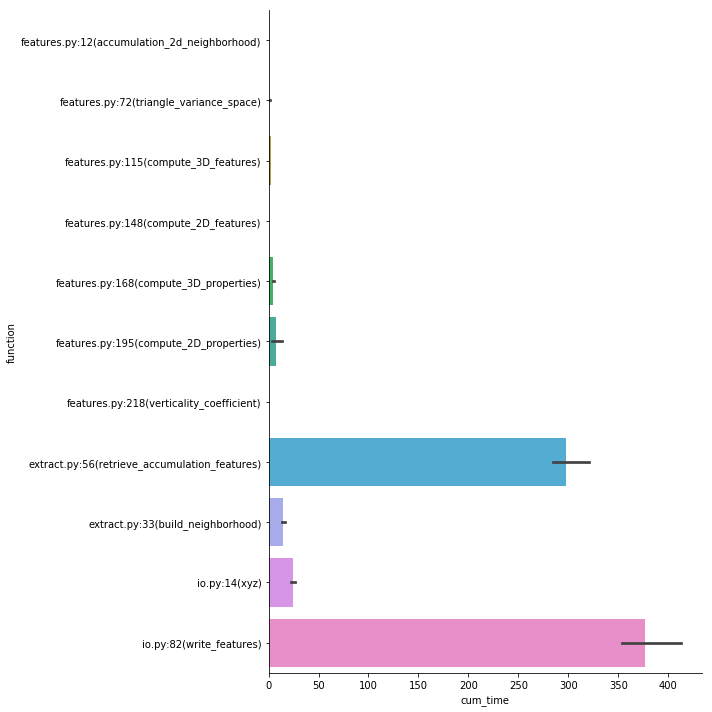

In [175]:
g = sns.catplot("cum_time", "function", data=graph_timers, kind="bar", size=10, height=2)

### Temps par itération

In [176]:
graph_iter_functions = ["features.py:72(triangle_variance_space)",
                        "extract.py:33(build_neighborhood)",
                        "features.py:115(compute_3D_features)",
                        "features.py:148(compute_2D_features)",
                        "features.py:168(compute_3D_properties)",
                        "features.py:195(compute_2D_properties)",
                        "features.py:218(verticality_coefficient)",
                        "extract.py:56(retrieve_accumulation_features)"]

In [177]:
graph_iter_mask = np.logical_and(timers["feature_set"] == "full",
                                 [f in graph_iter_functions for f in timers["function"]])
graph_iter_timers = timers.loc[graph_iter_mask]
graph_iter_timers.drop(["feature_set"], axis=1, inplace=True)

/home/rde/.virtualenvs/univers/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


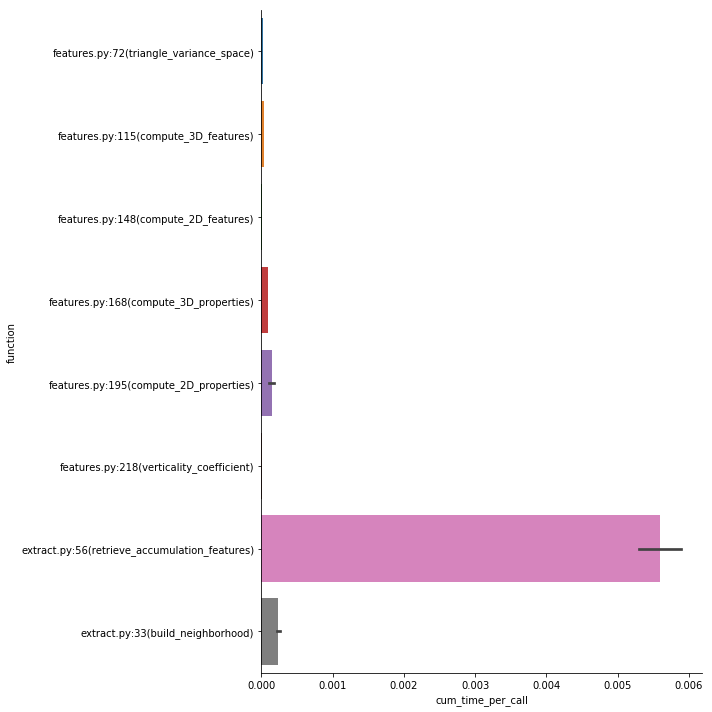

In [181]:
g = sns.catplot("cum_time_per_call", "function", data=graph_iter_timers, kind="bar", size=10, height=2)